In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image


# Helper Fuctions
In the following cell, I have implemented the helper functions needed to implement Gaussian and Laplacian filters

In [2]:
def gaussianBlur(image, k_size=5, sigma=1.5):
    height, width = image.shape

    kernal_shape = np.linspace(-(k_size - 1) / 2., 
                     (k_size - 1) / 2., 
                     k_size)
    x, y = np.meshgrid(kernal_shape, kernal_shape)
    kernel = np.exp(-0.5 * (x**2 + y**2) / sigma**2)
    kernel /= kernel.sum()

    pad_width = k_size // 2
    padded_image = np.pad(image, 
                          pad_width, 
                          mode='reflect')

    output = np.zeros_like(image)

    for i in range(height):
        for j in range(width):
            output[i, j] = np.sum(padded_image[i:i+k_size, j:j+k_size] * kernel)
    return output

def downsample(image):
    return image[::2, ::2]

def upsample(image, target_shape):
    result = np.zeros(target_shape)
    result[::2, ::2] = image
    return gaussianBlur(result, 5, 1.5)

In [3]:
def gaussianFilter(image, levels):
    gaussian_steps = [image]
    for _ in range(1, levels):
        image = gaussianBlur(image)
        image = downsample(image)
        gaussian_steps.append(image)
    return gaussian_steps

def laplacianFilter(gaussian_steps):
    laplacian_steps = []
    for i in range(len(gaussian_steps)-1):
        upsampled = upsample(gaussian_steps[i+1], gaussian_steps[i].shape)
        laplacian_layer = gaussian_steps[i] - upsampled
        laplacian_steps.append(laplacian_layer)
    laplacian_steps.append(gaussian_steps[-1])
    return laplacian_steps

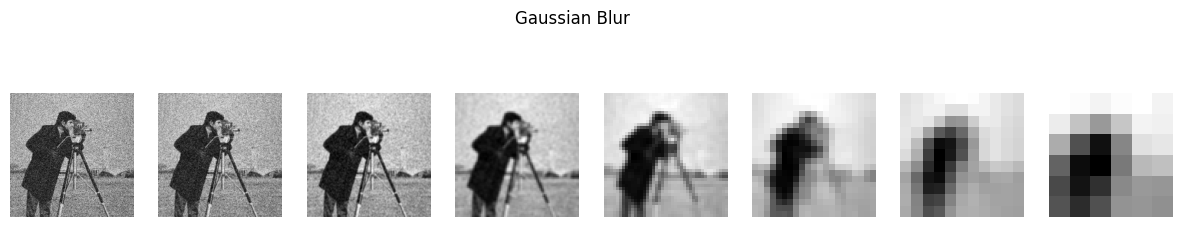

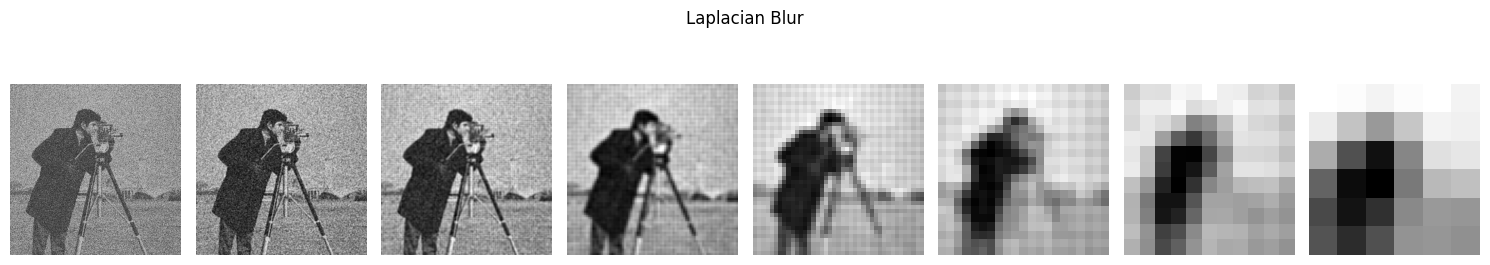

In [14]:
image_path = 'TEST_IMAGES/cameraman_noisy.jpg'
image = Image.open(image_path).convert('L')
image_np = np.array(image)

# Create Gaussian and Laplacian pyramids
gaussian_steps = gaussianFilter(image_np, levels=8)
laplacian_steps= laplacianFilter(gaussian_steps)

# Display all levels of the Gaussian and Laplacian pyramids
fig1, axs1 = plt.subplots(1, len(gaussian_steps), figsize=(15, 3))

fig1.suptitle("Gaussian Blur")
for i, gauss in enumerate(gaussian_steps):
    axs1[i].imshow(gauss, cmap='gray')
    axs1[i].axis('off')

fig2, axs2 = plt.subplots(1, len(laplacian_steps), figsize=(15, 3))

fig2.suptitle("Laplacian Blur")
for i, laplace in enumerate(laplacian_steps):
    axs2[i].imshow(laplace, cmap='gray')
    axs2[i].axis('off')


plt.tight_layout()
plt.show()

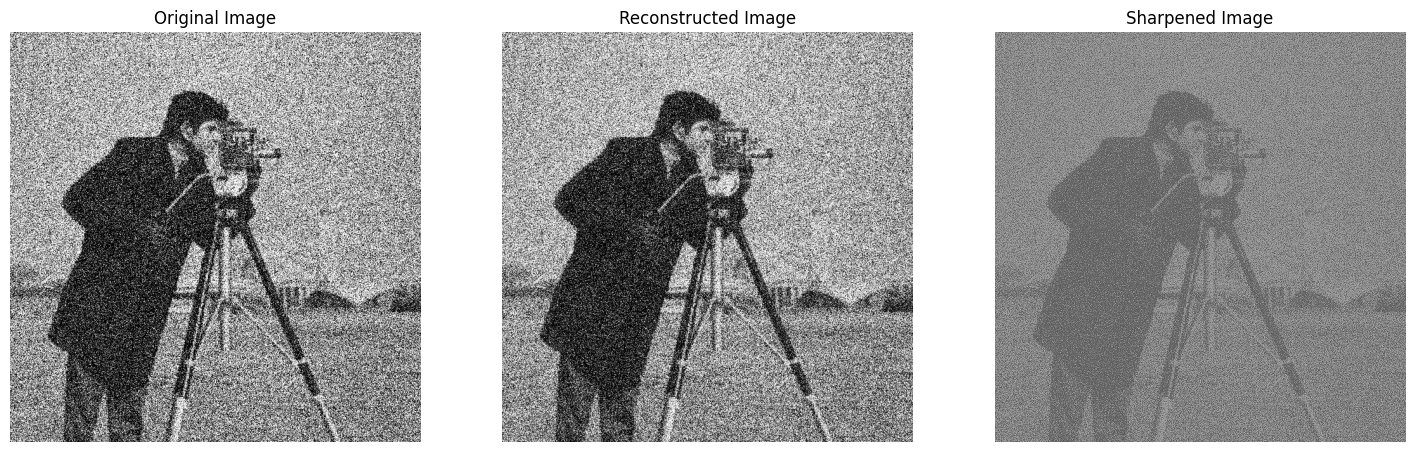

In [15]:

def sharpenImage(image, alpha=1.5):
    # A simple sharpening filter: enhances edges by adding a scaled Laplacian to the original image
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    pad_width = 1

    padded_image = np.pad(image, pad_width, mode='reflect')
    sharpened_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            sharpened_image[i, j] = np.sum(padded_image[i:i+3, j:j+3] * kernel) + alpha * image[i, j]

    return sharpened_image

def reconstructImage(laplacian_pyramid, damping_factor=0.1):
    image = laplacian_pyramid[-1]

    for i in range(len(laplacian_pyramid)-2, -1, -1):
        
        image = upsample(image, laplacian_pyramid[i].shape)
        high_freq = laplacian_pyramid[i] * damping_factor
        image += high_freq

    return image

# Load the image
image_path = 'TEST_IMAGES/cameraman_noisy.jpg'
image = Image.open(image_path).convert('L')
image_np = np.array(image)

# Create Gaussian and Laplacian pyramids
gaussian_pyramid = gaussianFilter(image_np, levels=4)
laplacian_pyramid = laplacianFilter(gaussian_pyramid)
reconstructed_image = reconstructImage(laplacian_pyramid, damping_factor=0.1)

# Apply sharpening to the reconstructed image
sharpened_image = sharpenImage(reconstructed_image, alpha=1.2)

# Display the original, reconstructed, and sharpened images
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(image_np, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.subplot(133)
plt.imshow(sharpened_image, cmap='gray')
plt.title('Sharpened Image')
plt.axis('off')

plt.show()
